In [ ]:
!pip install transformers datasets pandas torch scikit-learn
!pip uninstall torch -y
!pip install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load the Custom Dataset
custom_dataset_path = "/content/drive/MyDrive/base_data_full.csv"
custom_data = pd.read_csv(custom_dataset_path)

# Prepare the custom word set
custom_words = custom_data['word'].dropna().str.lower().unique()
custom_words_set = set(custom_words)

# Load the Reddit Dataset
reddit_path = "/content/drive/MyDrive/the-reddit-dataset-dataset-comments.csv"
reddit_data = pd.read_csv(reddit_path)

# Filter necessary columns: 'body' and 'sentiment'
reddit_data = reddit_data[['body', 'sentiment']]
reddit_data.columns = ['body', 'sentiment']  # Rename for clarity

# Clean and validate the Reddit data
reddit_data = reddit_data.dropna(subset=['body'])  # Remove rows with missing 'body'
reddit_data['body'] = reddit_data['body'].astype(str)  # Ensure all 'body' values are strings

# Filter Reddit data to include only rows with at least one word from the custom dataset
filtered_reddit_data = reddit_data[
    reddit_data['body'].str.contains('|'.join(custom_words_set), case=False, na=False)
]
print(f"Filtered Reddit dataset size: {len(filtered_reddit_data)}")

# Map sentiment to labels
filtered_reddit_data['label'] = filtered_reddit_data['sentiment'].apply(
    lambda x: 0 if x < 0 else (1 if x > 0 else 2)
)

# Convert to Hugging Face Dataset
filtered_reddit_dataset = Dataset.from_pandas(filtered_reddit_data[['body', 'label']])

# Load Pretrained BERTweet
model_name = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Tokenization Function
def tokenize_function(examples):
    return tokenizer(examples['body'], padding="max_length", truncation=True, max_length=128)

# Apply Tokenization
filtered_reddit_dataset = filtered_reddit_dataset.map(tokenize_function, batched=True)
filtered_reddit_dataset = filtered_reddit_dataset.rename_column("label", "labels")
filtered_reddit_dataset.set_format(type="torch", columns=['input_ids', 'attention_mask', 'labels'])

# Evaluation Metrics
def compute_metrics(pred):
    predictions = pred.predictions.argmax(-1)
    labels = pred.label_ids
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Evaluation Arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    logging_steps=10,
)

# Evaluate Original Model
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
)

eval_results = trainer.evaluate(eval_dataset=filtered_reddit_dataset)
print("Original Model Evaluation Results on Filtered Dataset:", eval_results)

# Save the original model for comparison
model.save_pretrained("/content/drive/MyDrive/original_bertweet_model")
tokenizer.save_pretrained("/content/drive/MyDrive/original_bertweet_tokenizer")

Filtered Reddit dataset size: 26687


<ipython-input-4-f26db4d8d4c2>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_reddit_data['label'] = filtered_reddit_data['sentiment'].apply(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/26687 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Original Model Evaluation Results on Filtered Dataset: {'eval_loss': 1.1153600215911865, 'eval_model_preparation_time': 0.0072, 'eval_accuracy': 0.17176902611758535, 'eval_precision': 0.44222107297672353, 'eval_recall': 0.17176902611758535, 'eval_f1': 0.07380583027100457, 'eval_runtime': 12386.1417, 'eval_samples_per_second': 2.155, 'eval_steps_per_second': 0.135}


('/content/drive/MyDrive/original_bertweet_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/original_bertweet_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/original_bertweet_tokenizer/vocab.txt',
 '/content/drive/MyDrive/original_bertweet_tokenizer/bpe.codes',
 '/content/drive/MyDrive/original_bertweet_tokenizer/added_tokens.json')

In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load Custom Dataset
custom_path = "/content/drive/MyDrive/base_data_full.csv"
custom_data = pd.read_csv(custom_path)

# Ensure correct data types
custom_data = custom_data.dropna()  # Remove missing values
custom_data['sentence'] = custom_data['sentence'].astype(str)  # Ensure sentences are strings
custom_data['sentiment'] = custom_data['sentiment'].str.lower()  # Normalize sentiment column to lowercase

# Map sentiment to numerical labels
sentiment_mapping = {"negative": 0, "positive": 1, "neutral": 2}
custom_data['label'] = custom_data['sentiment'].map(sentiment_mapping)

# Convert to Hugging Face Dataset
custom_dataset = Dataset.from_pandas(custom_data[['sentence', 'label']])

# Load Pretrained BERTweet
model_name = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Tokenization Function
def tokenize_function(examples):
    return tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=128)

custom_dataset = custom_dataset.map(tokenize_function, batched=True)
custom_dataset = custom_dataset.rename_column("label", "labels")
custom_dataset.set_format(type="torch", columns=['input_ids', 'attention_mask', 'labels'])

# Split Dataset for Training and Validation
custom_dataset = custom_dataset.train_test_split(test_size=0.2)
train_dataset = custom_dataset['train']
eval_dataset = custom_dataset['test']

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./finetuned_results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./finetuned_logs",
    logging_steps=10,
    save_strategy="epoch"
)

# Evaluation Metrics
def compute_metrics(pred):
    predictions = pred.predictions.argmax(-1)
    labels = pred.label_ids
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

# Fine-Tune the Model
trainer.train()

# Save the Fine-Tuned Model
model.save_pretrained("/content/drive/MyDrive/finetuned_bertweet_model")
tokenizer.save_pretrained("/content/drive/MyDrive/finetuned_bertweet_tokenizer")

# Evaluate Fine-Tuned Model on Filtered Reddit Dataset
eval_results = trainer.evaluate(eval_dataset=eval_dataset)
print("Fine-Tuned Model Evaluation Results on Custom Dataset:", eval_results)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2744 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.453800,0.386441,0.887067,0.852302,0.887067,0.869214
2,0.329400,0.379780,0.894353,0.858236,0.894353,0.875791
3,0.271600,0.365750,0.881603,0.870944,0.881603,0.876155


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fine-Tuned Model Evaluation Results on Custom Dataset: {'eval_loss': 0.365749716758728, 'eval_accuracy': 0.8816029143897997, 'eval_precision': 0.8709442898596071, 'eval_recall': 0.8816029143897997, 'eval_f1': 0.8761550648443098, 'eval_runtime': 245.7017, 'eval_samples_per_second': 2.234, 'eval_steps_per_second': 0.142, 'epoch': 3.0}


In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load the Custom Dataset
custom_dataset_path = "/content/drive/MyDrive/base_data_full.csv"
custom_data = pd.read_csv(custom_dataset_path)

# Prepare the custom word set
custom_words = custom_data['word'].dropna().str.lower().unique()
custom_words_set = set(custom_words)

# Load the Reddit Dataset
reddit_path = "/content/drive/MyDrive/the-reddit-dataset-dataset-comments.csv"
reddit_data = pd.read_csv(reddit_path)

# Filter necessary columns: 'body' and 'sentiment'
reddit_data = reddit_data[['body', 'sentiment']]
reddit_data.columns = ['body', 'sentiment']  # Rename for clarity

# Clean and validate the Reddit data
reddit_data = reddit_data.dropna(subset=['body'])  # Remove rows with missing 'body'
reddit_data['body'] = reddit_data['body'].astype(str)  # Ensure all 'body' values are strings

# Filter Reddit data to include only rows with at least one word from the custom dataset
filtered_reddit_data = reddit_data[
    reddit_data['body'].str.contains('|'.join(custom_words_set), case=False, na=False)
]
print(f"Filtered Reddit dataset size: {len(filtered_reddit_data)}")

# Map sentiment to labels
filtered_reddit_data['label'] = filtered_reddit_data['sentiment'].apply(
    lambda x: 0 if x < 0 else (1 if x > 0 else 2)
)

# Convert to Hugging Face Dataset
filtered_reddit_dataset = Dataset.from_pandas(filtered_reddit_data[['body', 'label']])


# Load Tokenizer (already used for tokenization in Parts 1 & 2)
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/finetuned_bertweet_tokenizer")

# Tokenization Function
def tokenize_function(examples):
    return tokenizer(examples['body'], padding="max_length", truncation=True, max_length=128)

# Apply Tokenization
filtered_reddit_dataset = filtered_reddit_dataset.map(tokenize_function, batched=True)
filtered_reddit_dataset = filtered_reddit_dataset.rename_column("label", "labels")
filtered_reddit_dataset.set_format(type="torch", columns=['input_ids', 'attention_mask', 'labels'])



Filtered Reddit dataset size: 26687


<ipython-input-3-9d2c795738c1>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_reddit_data['label'] = filtered_reddit_data['sentiment'].apply(
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Map:   0%|          | 0/26687 [00:00<?, ? examples/s]

In [ ]:
torch_save_path = "/content/drive/MyDrive/filtered_reddit_dataset.pt"

# Convert dataset to PyTorch Tensors
torch.save(filtered_reddit_dataset, torch_save_path)

In [ ]:

print("Evauation of FineTuned model")
# Load Original Model
# original_model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/original_bertweet_model")

# Load Fine-Tuned Model
finetuned_model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/finetuned_bertweet_model")

# Evaluation Metrics
def compute_metrics(pred):
    predictions = pred.predictions.argmax(-1)
    labels = pred.label_ids
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Evaluation Arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=32,
    logging_dir="./logs",
    logging_steps=10,
)

# Evaluate Model
finetuned_model_trainer = Trainer(
    model=finetuned_model,
    args=training_args,
    compute_metrics=compute_metrics,
)

#eval_results = finetuned_model_trainer.evaluate(eval_dataset=filtered_reddit_dataset)


# Evaluate Fine-Tuned Model on Filtered Reddit Dataset
finetuned_results = finetuned_model_trainer.evaluate(eval_dataset=filtered_reddit_dataset)
print("Fine-Tuned Model Results on Filtered Reddit Dataset:")
print(finetuned_results)

Evauation of FineTuned model


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Fine-Tuned Model Results on Filtered Reddit Dataset:
{'eval_loss': 1.5392875671386719, 'eval_model_preparation_time': 0.0068, 'eval_accuracy': 0.43140855097987785, 'eval_precision': 0.5470424163547183, 'eval_recall': 0.43140855097987785, 'eval_f1': 0.4351221395902677, 'eval_runtime': 11131.2788, 'eval_samples_per_second': 2.397, 'eval_steps_per_second': 0.075}


In [ ]:
print(finetuned_model_trainer)


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.82      0.80      0.81      9007
     Class 1       0.66      0.67      0.67     11690
     Class 2       0.62      0.63      0.62      9499

    accuracy                           0.70     30196
   macro avg       0.70      0.70      0.70     30196
weighted avg       0.70      0.70      0.70     30196



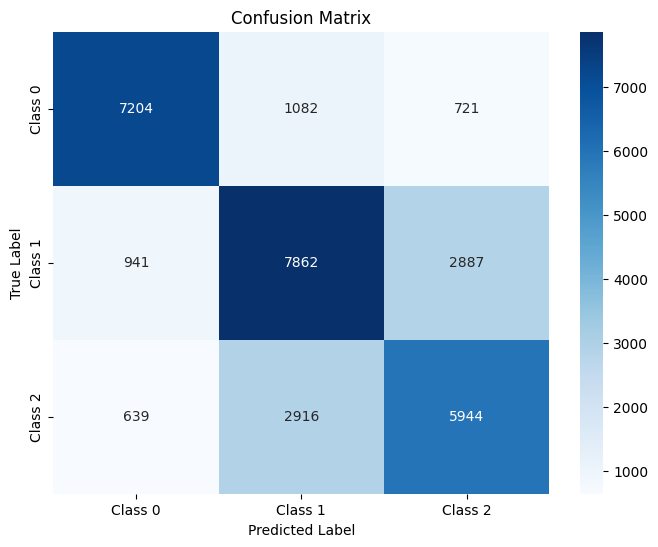

In [6]:

# Generate classification report
class_report = classification_report(true_labels, predicted_labels, target_names=['Class 0', 'Class 1', 'Class 2'])

print("\nClassification Report:")
print(class_report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
